In [1]:

import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:

def imread(path):
    img = cv2.imread(path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rgb2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def rgb2bin(img):
    img = rgb2gray(img)
    # img_bin = cv2.adaptiveThreshold(
    #     img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    t, img_bin = cv2.threshold(
        img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    # img_bin = 255-img_bin
    return img_bin


def imshow(img, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.show()


def find_best_contours(img_rgb):
    img_bin = rgb2bin(img_rgb)
    contours, hir = cv2.findContours(
        img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    # print('contours',contours)
    best_contours = max(contours, key=cv2.contourArea)
    return best_contours


def draw_contours(img, contours, index=-1, color=(0, 255, 0), thickness=3):
    img_copy = img.copy()
    cv2.drawContours(img_copy, contours, index, color, thickness)
    imshow(img_copy)


In [3]:
from tqdm import tqdm

def img_blure(imgs_path):
    for path in tqdm(imgs_path):
        img=cv2.imread(path)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=cv2.blur(img,ksize=(10,10))
        cv2.imwrite(path,img)


In [4]:

path = 'shapes/'

def chain_hist(img):
    lookup_table = {
        (1, 0): 0,
        (1, -1): 1,
        (0, -1): 2,
        (-1, -1): 3,
        (-1, 0): 4,
        (-1, 1): 5,
        (0, 1): 6,
        (1, 1): 7,

    }

    best_contour = find_best_contours(img)
    hist = np.zeros((8,))
    for i in range(len(best_contour)-1):
        x1, y1 = best_contour[i][0]
        x2, y2 = best_contour[i+1][0]
        dx = x1-x2
        dy = y1-y2
        code = lookup_table[(dx, dy)]
        hist[code] += 1
    return hist/hist.sum()


In [5]:
path = 'shapes/'

def create_df(data_path):
    class_dict={c:i for i,c in enumerate(sorted(os.listdir(data_path)))}
    df=[]
    for class_name,class_value in class_dict.items():
        class_directory=os.path.join(path,class_name)
        for file in os.listdir(class_directory):
            f_path=os.path.join(class_directory,file)
            if f_path.lower().endswith('.png'):
                df.append([f_path,class_value])

    df=pd.DataFrame(df,columns=['path','output'])
    return df
df =create_df(path)
print(df.shape)
print(df.head)

(14970, 2)
<bound method NDFrame.head of                            path  output
0        shapes/circle/1030.png       0
1        shapes/circle/1785.png       0
2         shapes/circle/829.png       0
3        shapes/circle/2273.png       0
4        shapes/circle/1917.png       0
...                         ...     ...
14965  shapes/triangle/2072.png       3
14966   shapes/triangle/538.png       3
14967  shapes/triangle/2334.png       3
14968  shapes/triangle/2843.png       3
14969   shapes/triangle/937.png       3

[14970 rows x 2 columns]>


In [6]:
circle_path=df[df['path'].str.contains('circle')]['path']

img_blure(circle_path)

100%|██████████| 3720/3720 [00:05<00:00, 718.49it/s]


In [7]:

triangle_path=df[df['path'].str.contains('triangle')]['path']

img_blure(triangle_path)

100%|██████████| 3720/3720 [00:04<00:00, 778.81it/s]


In [8]:

from tqdm import tqdm

def extract_feature(img_paths):
    n=len(img_paths)
    x=np.zeros((n,8))
    for i in tqdm(range(n)):
        f_path=img_paths[i]
        img=imread(f_path)
        feature=chain_hist(img)
        x[i]=feature
    return x
        

In [9]:

x=extract_feature(df['path'])
y=df['output']

100%|██████████| 14970/14970 [00:48<00:00, 310.23it/s]


In [10]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=0)

In [11]:
x_train[:3]
y_train[:3]

10203    2
5804     1
10843    2
Name: output, dtype: int64

In [12]:
from sklearn.svm import SVC
model=SVC()
model.fit(x_train,y_train)

SVC()

In [13]:
from sklearn.metrics import accuracy_score
y_pred_train=model.predict(x_train)
y_pred_test=model.predict(x_test)

print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test,y_pred_test))

0.9477049336768776
0.9394344244043643


In [14]:
def test_model(model,img):
    class_dict=[i for i in sorted(os.listdir(path))]  
    x=chain_hist(img)
    c=model.predict([x])[0]
    return class_dict[c]

In [15]:
test_model(model,imread('../data/shapes/circle/1.png'))

'circle'

In [16]:

def find_all_contours(img_rgb):
    img_bin = rgb2bin(img_rgb)
    contours, hir = cv2.findContours(
        img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    best_contours=sorted(contours,key=cv2.contourArea)
    return best_contours

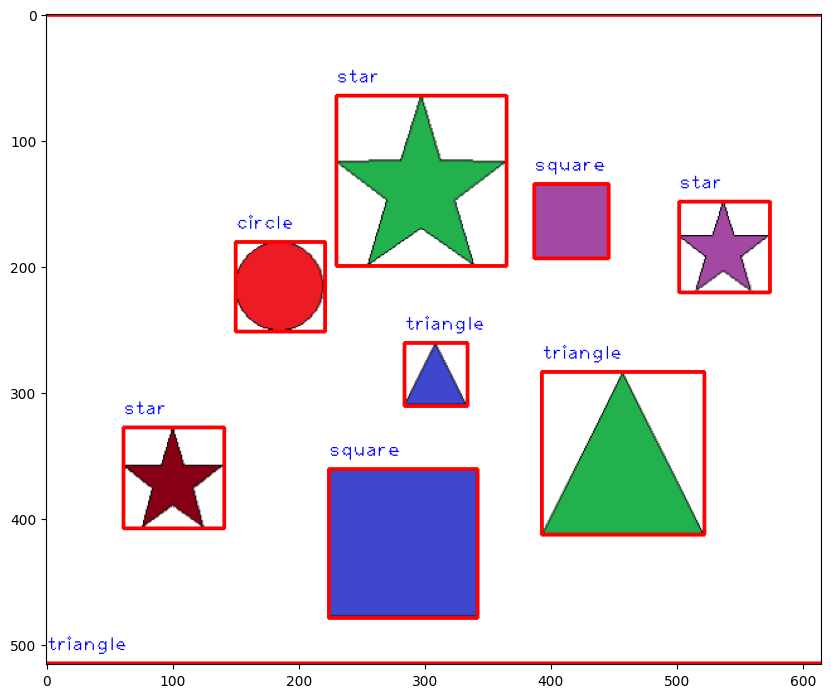

In [17]:
img=imread('../data/result2.png')
contours=find_all_contours(img)
img_copy=img.copy()
for contour in contours:
    x,y,w,h=cv2.boundingRect(contour)
    img_cut=img[y:y+h,x:x+w]
    class_dect=test_model(model,img_cut)
    cv2.rectangle(img_copy,(x,y),(x+w,y+h),(255,0,0),2)
    cv2.putText(img_copy,class_dect,(x,y-10),cv2.FONT_HERSHEY_PLAIN,1.01,(0,0,255),1)
imshow(img_copy)